In [1]:
# https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-gluon.html#Faster-modeling-with-gluon.nn.Sequential
%matplotlib inline

from __future__ import print_function
from time import time
from IPython.display import clear_output
import csv
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import nd, autograd, gluon

X0 = []
y0 = []
with open('snapshots_Xy_180810_114422.csv', 'rb') as f:
    rdr = csv.reader(f, delimiter=',')
    next(rdr)
    for row in rdr:
        X0.append([float(x) for x in row[1:-1]])
        y0.append(int(row[1]))


X1 = []
y1 = []
with open('snapshots_Xy_180723_141339.csv', 'rb') as f:
    rdr = csv.reader(f, delimiter=',')
    next(rdr)
    for row in rdr:
        X1.append([float(x) for x in row[1:-1]])
        y1.append(int(row[1]))
    
        
X0 = nd.array(X0)
y0 = nd.array(y0)      
X1 = nd.array(X1)
y1 = nd.array(y1)

mx.random.seed(4222)

sel = nd.random.shuffle(nd.arange(X0.shape[0]))
X0 = X0[sel,:]
y0 = y0[sel]

sel = nd.random.shuffle(nd.arange(X1.shape[0]))
X1 = X1[sel,:]
y1 = y1[sel]




num_of_samples, num_of_feats = X0.shape
num_of_samples = int(0.7 * num_of_samples)
batch_size = int(num_of_samples / 1)

X0train = X0[0:num_of_samples,:]
y0train = y0[0:num_of_samples]
X0test = X0[num_of_samples:,:]
y0test = y0[num_of_samples:]

print(' NUMBER OF FEATURES - %4d' %num_of_feats)
print('TRAINING DATASET #0 - SECURE: %4d | INSECURE: %4d' 
      %(sum(y0train==1).asscalar(), sum(y0train==0).asscalar()))
print(' TESTING DATASET #0 - SECURE: %4d | INSECURE: %4d' 
      %(sum(y0test==1).asscalar(), sum(y0test==0).asscalar()))

X1train = X1[0:num_of_samples,:]
y1train = y1[0:num_of_samples]
X1test = X1[num_of_samples:,:]
y1test = y1[num_of_samples:]


print(' NUMBER OF FEATURES - %4d' %num_of_feats)
print('TRAINING DATASET #1 - SECURE: %4d | INSECURE: %4d' 
      %(sum(y1train==1).asscalar(), sum(y1train==0).asscalar()))
print(' TESTING DATASET #1 - SECURE: %4d | INSECURE: %4d' 
      %(sum(y1test==1).asscalar(), sum(y1test==0).asscalar()))


train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X0train, y0train),
                                   batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X0test, y0test),
                                  batch_size=batch_size, shuffle=True)


update_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X1train, y1train),
                                   batch_size=batch_size, shuffle=True)
update_test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X1test, y1test),
                                  batch_size=batch_size, shuffle=True)

mdl_ctx = mx.gpu()
dat_ctx = mx.gpu()
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()


def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(mdl_ctx).reshape((-1, num_of_feats))
        label = label.as_in_context(mdl_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

def movavg(data, window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec


 NUMBER OF FEATURES -  525
TRAINING DATASET #0 - SECURE: 1710 | INSECURE: 1090
 TESTING DATASET #0 - SECURE:  732 | INSECURE:  468
 NUMBER OF FEATURES -  525
TRAINING DATASET #1 - SECURE: 1750 | INSECURE: 1050
 TESTING DATASET #1 - SECURE:  763 | INSECURE:  434


In [2]:
def nntrain2(algo, e1, e2, param):
    train_acc = []
    test_acc = []
    epo_time = []
    epo_loss = []
    cum_time = 0.
    
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(512, activation="relu"))
        net.add(gluon.nn.Dense(256, activation="relu"))
        net.add(gluon.nn.Dense(128, activation="relu"))
        net.add(gluon.nn.Dense(64))

    net.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=mdl_ctx)
    trainer = gluon.Trainer(net.collect_params(), algo, param)

    for e in range(e1):
        tic = time()
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            data = data.as_in_context(mdl_ctx).reshape((-1, num_of_feats))
            label = label.as_in_context(mdl_ctx)
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(data.shape[0])
            cumulative_loss += nd.sum(loss).asscalar()

        train_acc.append(evaluate_accuracy(train_data, net))
        test_acc.append(evaluate_accuracy(test_data, net))
        epo_time.append(time() - tic)
        cum_time += time() - tic
        epo_loss.append(cumulative_loss/num_of_samples)
        
        clear_output(wait=True)
        print("Epoch #%4d. Train_acc: %9.8f, Test_acc: %9.8f, Time: %9.8f, Loss: %12.8f" %
              (e+1, train_acc[e], test_acc[e], epo_time[e], epo_loss[e]))                

    for e in range(e2):
        tic = time()
        cumulative_loss = 0
        for i, (data, label) in enumerate(update_data):
            data = data.as_in_context(mdl_ctx).reshape((-1, num_of_feats))
            label = label.as_in_context(mdl_ctx)
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(data.shape[0])
            cumulative_loss += nd.sum(loss).asscalar()

        train_acc.append(evaluate_accuracy(update_data, net))
        test_acc.append(evaluate_accuracy(update_test_data, net))
        epo_time.append(time() - tic)
        cum_time += time() - tic
        epo_loss.append(cumulative_loss/num_of_samples)
        
        clear_output(wait=True)
        print("Epoch #%4d. Train_acc: %9.8f, Test_acc: %9.8f, Time: %9.8f, Loss: %12.8f" %
              (e+1, train_acc[e], test_acc[e], epo_time[e], epo_loss[e]))    
    
    print("    >>> Completed! Training time: %9.8f" %cum_time)
    for i in range((e1+e2)/500):
        idx = 500 * (i+1)
        print('With %4d Epochs: train_acc: %9.8f, test_acc: %9.8f, loss: %9.8f, cum_time: %8.4fs' 
              %(idx, train_acc[idx-1], test_acc[idx-1], epo_loss[idx-1], sum(epo_time[0:idx-1])))
    
    print('Preset Learning Rate: %s' %trainer._optimizer._get_lr(-1))
    return train_acc, test_acc, epo_time, epo_loss, cum_time    

In [5]:
ma = 20
num_of_train_epochs = ma + 200
num_of_update_epochs = ma + 400
nonadarate = 2e-5
adarate = 2e-4

In [6]:
# **************** SGD ****************
sgd_train_acc, sgd_test_acc, sgd_epo_time, sgd_epo_loss, sgd_cum_time = nntrain2('sgd', num_of_train_epochs,
                                                                                 num_of_update_epochs,
                                                                                {'learning_rate': nonadarate})

Epoch # 420. Train_acc: 0.86857143, Test_acc: 0.84795322, Time: 0.11963415, Loss:   0.30463414
    >>> Completed! Training time: 83.59305215
With  500 Epochs: train_acc: 0.88714286, test_acc: 0.86299081, loss: 0.25843972, cum_time:  65.2863s
Preset Learning Rate: 2e-05


In [12]:
# **************** SGD-M ****************
sgdm_train_acc, sgdm_test_acc, sgdm_epo_time, sgdm_epo_loss, sgdm_cum_time = nntrain2('sgd', num_of_train_epochs,
                                                                                      num_of_update_epochs,
                                                                                      {'learning_rate': nonadarate,
                                                                                       'momentum': 0.009})

Epoch # 420. Train_acc: 0.82857143, Test_acc: 0.79532164, Time: 0.17280507, Loss:   0.39490034
    >>> Completed! Training time: 91.76242566
With  500 Epochs: train_acc: 0.84857143, test_acc: 0.82121972, loss: 0.34014683, cum_time:  71.4854s
Preset Learning Rate: 2e-05


In [6]:
# **************** NAG ****************
nag_train_acc, nag_test_acc, nag_epo_time, nag_epo_loss, nag_cum_time = nntrain2('nag', num_of_train_epochs,
                                                                                 num_of_update_epochs, 
                                                                                 {'learning_rate': nonadarate,
                                                                                  'momentum': 0.})

Epoch #4050. Train_acc: 0.94392857, Test_acc: 0.92063492, Time: 0.14971995, Loss:   0.14197394
    >>> Completed! Training time: 822.81043434
With  500 Epochs: train_acc: 0.92321429, test_acc: 0.91583333, loss: 0.17269925, cum_time:  67.2173s
With 1000 Epochs: train_acc: 0.92964286, test_acc: 0.91750000, loss: 0.15781194, cum_time: 134.7650s
With 1500 Epochs: train_acc: 0.94714286, test_acc: 0.93833333, loss: 0.12664189, cum_time: 202.3504s
With 2000 Epochs: train_acc: 0.94892857, test_acc: 0.93916667, loss: 0.11935978, cum_time: 269.7880s
With 2500 Epochs: train_acc: 0.92178571, test_acc: 0.90810359, loss: 0.19101127, cum_time: 337.2844s
With 3000 Epochs: train_acc: 0.93428571, test_acc: 0.92147034, loss: 0.16351670, cum_time: 404.5891s
With 3500 Epochs: train_acc: 0.94107143, test_acc: 0.92230576, loss: 0.14793536, cum_time: 471.8711s
With 4000 Epochs: train_acc: 0.94392857, test_acc: 0.92063492, loss: 0.14253905, cum_time: 539.2054s
With 4500 Epochs: train_acc: 0.94500000, test_acc:

In [7]:
# **************** NAG-M ****************
nagm_train_acc, nagm_test_acc, nagm_epo_time, nagm_epo_loss, nagm_cum_time = nntrain2('nag', num_of_train_epochs,
                                                                                      num_of_update_epochs,
                                                                                      {'learning_rate': nonadarate,
                                                                                       'momentum': 0.009})

Epoch #4050. Train_acc: 0.93464286, Test_acc: 0.91144528, Time: 0.12630105, Loss:   0.16489264
    >>> Completed! Training time: 825.21317291
With  500 Epochs: train_acc: 0.91642857, test_acc: 0.91166667, loss: 0.20393661, cum_time:  67.6993s
With 1000 Epochs: train_acc: 0.94178571, test_acc: 0.93000000, loss: 0.14216255, cum_time: 135.1989s
With 1500 Epochs: train_acc: 0.91821429, test_acc: 0.90583333, loss: 0.22809256, cum_time: 202.8492s
With 2000 Epochs: train_acc: 0.95321429, test_acc: 0.94083333, loss: 0.11720540, cum_time: 270.6183s
With 2500 Epochs: train_acc: 0.91821429, test_acc: 0.89473684, loss: 0.20528700, cum_time: 338.2502s
With 3000 Epochs: train_acc: 0.92964286, test_acc: 0.91228070, loss: 0.16666149, cum_time: 405.6506s
With 3500 Epochs: train_acc: 0.93785714, test_acc: 0.91311612, loss: 0.15371137, cum_time: 473.3608s
With 4000 Epochs: train_acc: 0.94214286, test_acc: 0.91478697, loss: 0.14616830, cum_time: 540.8878s
With 4500 Epochs: train_acc: 0.92964286, test_acc:

In [8]:
# # **************** TestAlgo ****************
# algo_train_acc, algo_test_acc, algo_epo_time, algo_epo_loss, algo_cum_time = nntrain2('rmsprop', num_of_train_epochs,
#                                                                                       num_of_update_epochs,
#                                                                                       {'learning_rate': nonadarate})

In [9]:
# **************** AdaGrad ****************
adag_train_acc, adag_test_acc, adag_epo_time, adag_epo_loss, adag_cum_time = nntrain2('adagrad', num_of_train_epochs,
                                                                                      num_of_update_epochs,
                                                                                      {'learning_rate': adarate})

Epoch #4050. Train_acc: 0.93250000, Test_acc: 0.90810359, Time: 0.13318896, Loss:   2.48249128
    >>> Completed! Training time: 828.73757792
With  500 Epochs: train_acc: 0.84892857, test_acc: 0.84250000, loss: 12.19136440, cum_time:  67.8908s
With 1000 Epochs: train_acc: 0.88107143, test_acc: 0.87416667, loss: 8.13602539, cum_time: 136.0778s
With 1500 Epochs: train_acc: 0.90000000, test_acc: 0.89166667, loss: 6.26858189, cum_time: 204.0943s
With 2000 Epochs: train_acc: 0.90785714, test_acc: 0.90083333, loss: 5.06653739, cum_time: 272.0399s
With 2500 Epochs: train_acc: 0.91071429, test_acc: 0.88053467, loss: 4.42604667, cum_time: 339.8122s
With 3000 Epochs: train_acc: 0.92357143, test_acc: 0.89891395, loss: 3.44270787, cum_time: 407.7969s
With 3500 Epochs: train_acc: 0.92857143, test_acc: 0.90225564, loss: 2.84005929, cum_time: 475.7990s
With 4000 Epochs: train_acc: 0.93071429, test_acc: 0.90726817, loss: 2.65981829, cum_time: 543.6143s
With 4500 Epochs: train_acc: 0.93464286, test_acc

In [10]:
# **************** ADAM ****************
adam_train_acc, adam_test_acc, adam_epo_time, adam_epo_loss, adam_cum_time = nntrain2('adam', num_of_train_epochs,
                                                                                      num_of_update_epochs, 
                                                                                      {'learning_rate': adarate})

Epoch #4050. Train_acc: 0.99678571, Test_acc: 0.97326650, Time: 0.13224602, Loss:   0.01571555
    >>> Completed! Training time: 879.03390479
With  500 Epochs: train_acc: 0.95642857, test_acc: 0.94500000, loss: 1.25328038, cum_time:  72.0993s
With 1000 Epochs: train_acc: 0.96821429, test_acc: 0.96416667, loss: 1.40338065, cum_time: 144.4313s
With 1500 Epochs: train_acc: 0.98250000, test_acc: 0.97166667, loss: 0.43691620, cum_time: 216.7344s
With 2000 Epochs: train_acc: 0.98928571, test_acc: 0.97666667, loss: 0.19355715, cum_time: 289.0567s
With 2500 Epochs: train_acc: 0.96500000, test_acc: 0.95238095, loss: 1.02042097, cum_time: 361.2409s
With 3000 Epochs: train_acc: 0.99178571, test_acc: 0.97243108, loss: 0.07004333, cum_time: 433.3455s
With 3500 Epochs: train_acc: 0.98750000, test_acc: 0.96574770, loss: 0.22904334, cum_time: 505.6218s
With 4000 Epochs: train_acc: 0.99714286, test_acc: 0.97076023, loss: 0.02417241, cum_time: 577.8266s
With 4500 Epochs: train_acc: 0.98857143, test_acc:

In [5]:
# **************** NADAM ****************
nadam_train_acc, nadam_test_acc, nadam_epo_time, nadam_epo_loss, nadam_cum_time = nntrain2('nadam', num_of_train_epochs,
                                                                                           num_of_update_epochs, 
                                                                                           {'learning_rate': adarate/2})

Epoch #4050. Train_acc: 0.87000000, Test_acc: 0.86716792, Time: 0.12908888, Loss:  23.24524414
    >>> Completed! Training time: 865.15241027
With  500 Epochs: train_acc: 0.93892857, test_acc: 0.93583333, loss: 5.29506557, cum_time:  72.7260s
With 1000 Epochs: train_acc: 0.95750000, test_acc: 0.95083333, loss: 3.33295968, cum_time: 145.3805s
With 1500 Epochs: train_acc: 0.71785714, test_acc: 0.71000000, loss: 75.88194196, cum_time: 216.0135s
With 2000 Epochs: train_acc: 0.96535714, test_acc: 0.96083333, loss: 2.52233067, cum_time: 286.6840s
With 2500 Epochs: train_acc: 0.94571429, test_acc: 0.92731830, loss: 6.55970773, cum_time: 357.2324s
With 3000 Epochs: train_acc: 0.93678571, test_acc: 0.92982456, loss: 6.40497070, cum_time: 427.6634s
With 3500 Epochs: train_acc: 0.97678571, test_acc: 0.95405180, loss: 1.36874756, cum_time: 498.0965s
With 4000 Epochs: train_acc: 0.98035714, test_acc: 0.95405180, loss: 0.94416469, cum_time: 568.6027s
With 4500 Epochs: train_acc: 0.97821429, test_acc

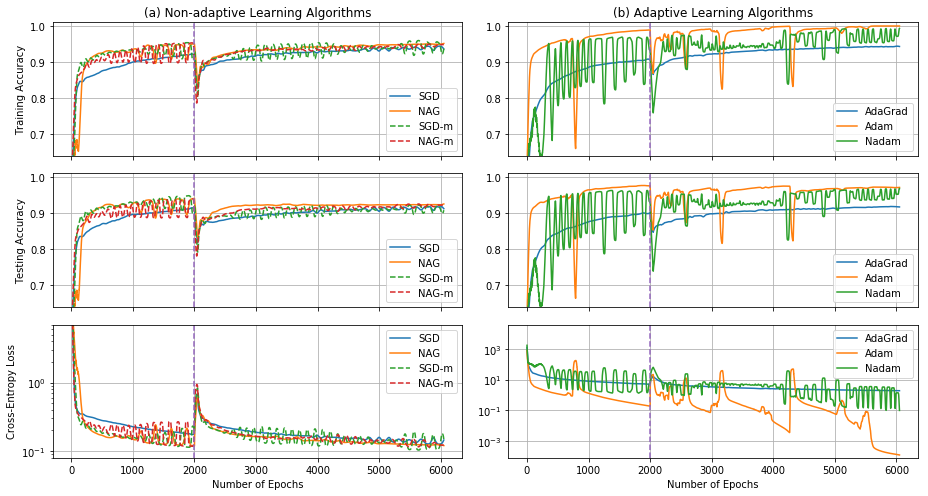

In [48]:
# **************** CombinedPlots ****************
fig_combined, ((ax11,ax12), 
               (ax21,ax22), 
               (ax31,ax32)) = plt.subplots(3, 2, sharex='col', figsize=(13, 7))

ax11.grid(True)
ax11.plot(movavg(sgd_train_acc, ma))
ax11.plot(movavg(nag_train_acc, ma))
ax11.plot(movavg(sgdm_train_acc, ma), ls='--')
ax11.plot(movavg(nagm_train_acc, ma), ls='--')
ax11.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='lower right')
ax11.set_title('(a) Non-adaptive Learning Algorithms')
ax11.set_ylabel('Training Accuracy')
ax11.set_ylim([0.64, 1.01])
# ax11.set_xlim([-100, 2100])

ax12.grid(True)
ax12.plot(movavg(adag_train_acc, ma))
ax12.plot(movavg(adam_train_acc, ma))
ax12.plot(movavg(nadam_train_acc, ma))
# ax12.plot(movavg(algo_train_acc, ma))
ax12.legend(['AdaGrad', 'Adam', 'Nadam'], loc='lower right')
ax12.set_title('(b) Adaptive Learning Algorithms')
ax12.set_ylim([0.64, 1.01])

ax21.grid(True)
ax21.plot(movavg(sgd_test_acc, ma))
ax21.plot(movavg(nag_test_acc, ma))
ax21.plot(movavg(sgdm_test_acc, ma), ls='--')
ax21.plot(movavg(nagm_test_acc, ma), ls='--')
ax21.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='lower right')
ax21.set_ylabel('Testing Accuracy')
ax21.set_ylim([0.64, 1.01])
# ax21.set_xlim([-100, 2100])

ax22.grid(True)
ax22.plot(movavg(adag_test_acc, ma))
ax22.plot(movavg(adam_test_acc, ma))
ax22.plot(movavg(nadam_test_acc, ma))
# ax22.plot(movavg(algo_test_acc, ma))
ax22.legend(['AdaGrad', 'Adam', 'Nadam'], loc='lower right')
ax22.set_ylim([0.64, 1.01])

ax31.grid(True)
ax31.set_xlabel('Number of Epochs')
ax31.set_ylabel('Cross-Entropy Loss')
ax31.plot(movavg(sgd_epo_loss,ma))
ax31.plot(movavg(nag_epo_loss,ma))
ax31.plot(movavg(sgdm_epo_loss, ma), ls='--')
ax31.plot(movavg(nagm_epo_loss, ma), ls='--')
ax31.set_yscale("log", nonposy='clip')
ax31.set_ylim([0.8e-1, 0.7e1])
ax31.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='upper right')

ax32.grid(True)
ax32.set_xlabel('Number of Epochs')
ax32.plot(movavg(adag_epo_loss,ma))
ax32.plot(movavg(adam_epo_loss,ma))
ax32.plot(movavg(nadam_epo_loss,ma))
ax32.set_ylim([0.8e-4, 4e4])
ax32.set_yscale("log", nonposy='clip')
ax32.legend(['AdaGrad', 'Adam', 'Nadam'], loc='upper right')



ax11.axvline(x=2000, c='tab:purple', ls='--')
ax21.axvline(x=2000, c='tab:purple', ls='--')
ax31.axvline(x=2000, c='tab:purple', ls='--')
ax12.axvline(x=2000, c='tab:purple', ls='--')
ax22.axvline(x=2000, c='tab:purple', ls='--')
ax32.axvline(x=2000, c='tab:purple', ls='--')


fig_combined.tight_layout()
fig_combined.savefig('combined.eps', format='eps')

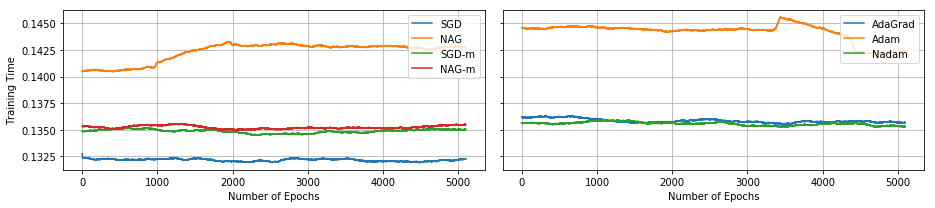

In [16]:
fig_time, (axt11,axt12) = plt.subplots(1,2, sharex='col', sharey='row', figsize=(13, 3))

axt11.grid(True)
axt11.plot(movavg(sgd_epo_time, 20*ma))
axt11.plot(movavg(sgdm_epo_time, 20*ma))
axt11.plot(movavg(nag_epo_time, 20*ma))
axt11.plot(movavg(nagm_epo_time, 20*ma))
axt11.set_xlabel('Number of Epochs')
axt11.set_ylabel('Training Time')
axt11.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='upper right')

axt12.grid(True)
axt12.plot(movavg(adag_epo_time, 20*ma))
axt12.plot(movavg(adam_epo_time, 20*ma))
axt12.plot(movavg(nadam_epo_time, 20*ma))
axt12.legend(['AdaGrad', 'Adam', 'Nadam'], loc='upper right')
axt12.set_xlabel('Number of Epochs')

fig_time.tight_layout()
fig_time.savefig('combined_time.eps', format='eps')


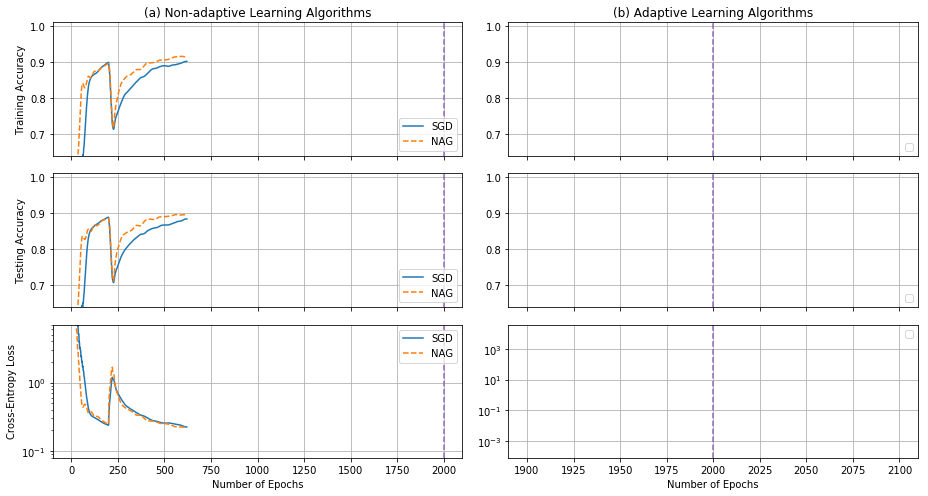

In [10]:
# **************** CombinedPlots ****************
fig_combined, ((ax11,ax12), 
               (ax21,ax22), 
               (ax31,ax32)) = plt.subplots(3, 2, sharex='col', figsize=(13, 7))

ax11.grid(True)
ax11.plot(movavg(sgd_train_acc, ma))
# ax11.plot(movavg(nag_train_acc, ma))
ax11.plot(movavg(sgdm_train_acc, ma), ls='--')
# ax11.plot(movavg(nagm_train_acc, ma), ls='--')
ax11.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='lower right')
ax11.set_title('(a) Non-adaptive Learning Algorithms')
ax11.set_ylabel('Training Accuracy')
ax11.set_ylim([0.64, 1.01])
# ax11.set_xlim([-100, 2100])

ax12.grid(True)
# ax12.plot(movavg(adag_train_acc, ma))
# ax12.plot(movavg(adam_train_acc, ma))
# ax12.plot(movavg(nadam_train_acc, ma))
# ax12.plot(movavg(algo_train_acc, ma))
ax12.legend(['AdaGrad', 'Adam', 'Nadam'], loc='lower right')
ax12.set_title('(b) Adaptive Learning Algorithms')
ax12.set_ylim([0.64, 1.01])

ax21.grid(True)
ax21.plot(movavg(sgd_test_acc, ma))
# ax21.plot(movavg(nag_test_acc, ma))
ax21.plot(movavg(sgdm_test_acc, ma), ls='--')
# ax21.plot(movavg(nagm_test_acc, ma), ls='--')
ax21.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='lower right')
ax21.set_ylabel('Testing Accuracy')
ax21.set_ylim([0.64, 1.01])
# ax21.set_xlim([-100, 2100])

ax22.grid(True)
# ax22.plot(movavg(adag_test_acc, ma))
# ax22.plot(movavg(adam_test_acc, ma))
# ax22.plot(movavg(nadam_test_acc, ma))
# ax22.plot(movavg(algo_test_acc, ma))
ax22.legend(['AdaGrad', 'Adam', 'Nadam'], loc='lower right')
ax22.set_ylim([0.64, 1.01])

ax31.grid(True)
ax31.set_xlabel('Number of Epochs')
ax31.set_ylabel('Cross-Entropy Loss')
ax31.plot(movavg(sgd_epo_loss,ma))
# ax31.plot(movavg(nag_epo_loss,ma))
ax31.plot(movavg(sgdm_epo_loss, ma), ls='--')
# ax31.plot(movavg(nagm_epo_loss, ma), ls='--')
ax31.set_yscale("log", nonposy='clip')
ax31.set_ylim([0.8e-1, 0.7e1])
ax31.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='upper right')

ax32.grid(True)
ax32.set_xlabel('Number of Epochs')
# ax32.plot(movavg(adag_epo_loss,ma))
# ax32.plot(movavg(adam_epo_loss,ma))
# ax32.plot(movavg(nadam_epo_loss,ma))
ax32.set_ylim([0.8e-4, 4e4])
ax32.set_yscale("log", nonposy='clip')
ax32.legend(['AdaGrad', 'Adam', 'Nadam'], loc='upper right')


ax11.axvline(x=2000, c='tab:purple', ls='--')
ax21.axvline(x=2000, c='tab:purple', ls='--')
ax31.axvline(x=2000, c='tab:purple', ls='--')
ax12.axvline(x=2000, c='tab:purple', ls='--')
ax22.axvline(x=2000, c='tab:purple', ls='--')
ax32.axvline(x=2000, c='tab:purple', ls='--')


fig_combined.tight_layout()
fig_combined.savefig('single.eps', format='eps')